In [61]:
#from model import *
from data import *
from torch.optim import Adam, lr_scheduler
from torchvision import models
import sklearn
from sklearn.ensemble import RandomForestClassifier

Load Data

In [80]:
bs = 256
train_data, train_labels, val_data, val_labels = get_data()
training_set = Dataset(train_data, train_labels)
val_set = Dataset(val_data, val_labels)
training_generator = torch.utils.data.DataLoader(training_set, batch_size = bs, shuffle = True, num_workers = 6)
val_generator = torch.utils.data.DataLoader(val_set, batch_size = bs, shuffle = True, num_workers = 6)

65605


Initialize the Model

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

#Define the Neural Network
class baseline(nn.Module):
    def __init__(self):
        super(baseline, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size=4)
        self.conv2 = nn.Conv2d(128, 256, kernel_size=2)
        self.fc1 = nn.Linear(1024, 50)
        self.fc2 = nn.Linear(50, 1)
        self.sm = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d((self.conv2(x)), 2))
        x = torch.flatten(x, start_dim = 1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return self.sm(x)

In [6]:
model = baseline()
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr = .1)
lrs = lr_scheduler.LinearLR(optimizer, total_iters=25)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

Training Procedure

Epoch: 0 Train Loss 0.06366771410102956 Val Loss: 0.06357505626510829
Train Acc: 0.5083795043139909 Val Acc: 0.48433493589743587
Epoch: 1 Train Loss 0.06280236541351769 Val Loss: 0.06357600877527148
Train Acc: 0.5059971610133649 Val Acc: 0.48910256410256414
Epoch: 2 Train Loss 0.06279679884028155 Val Loss: 0.06343177717644721
Train Acc: 0.5047552145012124 Val Acc: 0.51328125
Epoch: 3 Train Loss 0.06280215487640817 Val Loss: 0.06342864502221346
Train Acc: 0.5077911327045621 Val Acc: 0.5140758547008547
Epoch: 4 Train Loss 0.0628138954489259 Val Loss: 0.06376070412807167
Train Acc: 0.503732888541138 Val Acc: 0.4859241452991453
Epoch: 5 Train Loss 0.0627943252766272 Val Loss: 0.06344335729954764
Train Acc: 0.5018241502424857 Val Acc: 0.5140758547008547
Epoch: 6 Train Loss 0.06279122375417501 Val Loss: 0.0636106277233921
Train Acc: 0.5056715851096825 Val Acc: 0.4859241452991453
Epoch: 7 Train Loss 0.0627667714288691 Val Loss: 0.0641681847628206
Train Acc: 0.5090154567050132 Val Acc: 0.48512

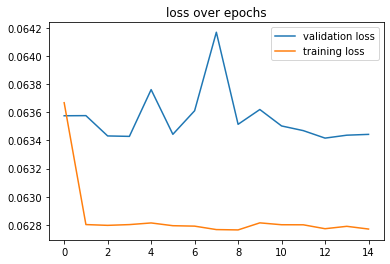

In [7]:
#Record to plot later
epoch_train = []
epoch_val = []
for epoch in range(10):

    running_loss = 0
    val_loss = 0
    train_acc = []
    val_acc = []

    #Main Training Procedure
    for local_batch, local_labels in training_generator:

        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        optimizer.zero_grad()
        outputs = torch.squeeze(model(local_batch))
        loss = criterion(outputs, local_labels)
        loss.backward()
        optimizer.step()
        lrs.step()

        train_acc.append(np.mean(((outputs.data.cpu().numpy() - local_labels.data.cpu().numpy())**2 < .25)))
        running_loss += loss.item() / (4*bs)

    #Validation Proceudre
    for local_batch, local_labels in val_generator:

        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        outputs = torch.squeeze(model(local_batch))
        loss = criterion(outputs, local_labels)

        val_acc.append(np.mean(((outputs.data.cpu().numpy() - local_labels.data.cpu().numpy())**2 < .25)))
        val_loss += loss.item() / bs

    print('Epoch:', epoch, 'Train Loss', running_loss, 'Val Loss:', val_loss)
    print('Train Acc:', np.mean(np.array(train_acc)), 'Val Acc:', np.mean(np.array(val_acc)))
    epoch_train.append(running_loss)
    epoch_val.append(val_loss)

plt.figure()
plt.title('loss over epochs')
plt.plot(epoch_val, label=f'validation loss')
plt.plot(epoch_train, label=f'training loss')
plt.legend()
plt.show()


Test outputs

In [59]:
torch.squeeze(model(torch.randn(10, 1, 16, 16)))

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9992,
        1.0000], grad_fn=<SqueezeBackward0>)

Other ML Methods

In [9]:
from sklearn.linear_model import LogisticRegression

bin_df = pd.read_hdf('/Users/lukemcdermott/Desktop/Physics/spectral_templates_data_version_june20.h5', key = '/binaries')
sin_df = pd.read_hdf('/Users/lukemcdermott/Desktop/Physics/spectral_templates_data_version_june20.h5', key = '/singles')
     
#Prep data for NN
bin_data = bin_df.iloc[:,:441].to_numpy() #np.zeros(bin_df.shape[0])])
sin_data = sin_df.iloc[:,:441].to_numpy() #np.zeros(bin_df.shape[0])])

bin_data, sin_data  = reduce_dim(bin_data, sin_data, 2)
sin_data = generate_data(sin_data, 3, 40000)
data, labels = add_labels(bin_data, sin_data)
idx = np.arange(len(labels))
np.random.shuffle(idx)
data = data[idx]
labels = labels[idx]

train_data, train_labels, test_data, test_labels = split_data(data, labels)

clf = LogisticRegression(random_state = 0).fit(train_data, train_labels)

65605


In [27]:
print(clf.predict(data[:10, :]))
print(clf.predict_proba(data[:10, :]))
print(clf.score(test_data,test_labels))
d = clf.decision_function(test_data)

[0 0 0 0 0 1 1 0 0 0]
[[0.53074304 0.46925696]
 [0.51682198 0.48317802]
 [0.51729058 0.48270942]
 [0.5023042  0.4976958 ]
 [0.52962039 0.47037961]
 [0.49820695 0.50179305]
 [0.49262233 0.50737767]
 [0.52522718 0.47477282]
 [0.5305802  0.4694198 ]
 [0.51416741 0.48583259]]
0.5631020607243019


Random Forests

In [84]:
#train_data, train_labels, val_data, val_labels = train_data.numpy(), train_labels.numpy(), val_data.numpy(), val_labels.numpy()
rf = RandomForestClassifier(max_depth = 15, random_state = 0)
rf.fit(train_data.reshape(np.shape(train_labels)[0], 256), train_labels)
print(rf.score(val_data.reshape(np.shape(val_labels)[0], 256),val_labels))

0.9653700768199001


In [95]:
#Parameters to try:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 3)]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


{'n_estimators': [200, 600, 1000], 'max_features': ['sqrt'], 'max_depth': [5, 17, 30, None], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


In [98]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 30, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(train_data.reshape(np.shape(train_labels)[0], 256), train_labels)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=15.2min
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=15.3min
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=25.1min
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=25.2min
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=25.2min
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=25.4min
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 17, 30, None],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [200, 600, 1000]},
                   random_state=42, verbose=2)

In [99]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 17,
 'bootstrap': False}

In [102]:
print(rf_random.score(val_data.reshape(np.shape(val_labels)[0], 256), val_labels))

0.9714059261065724


In [103]:
#Load Dataframes
b = pd.read_hdf('/Users/lukemcdermott/Desktop/Physics/spectral_templates_data_version_june20.h5', key = '/binaries')
s = pd.read_hdf('/Users/lukemcdermott/Desktop/Physics/spectral_templates_data_version_june20.h5', key = '/singles')
     
    #Prep data for NN
b = bin_df.iloc[:,:441].to_numpy() #np.zeros(bin_df.shape[0])])
s = sin_df.iloc[:,:441].to_numpy() #np.zeros(bin_df.shape[0])])

b, s  = reduce_dim(b, s, 256)

In [114]:
d = rf_random.predict(s)
c = rf_random.predict(b)

In [118]:
sum = 0
for i in c:
    sum += i

print(1 - sum / len(c))

0.736359741001714
